In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from collections import deque

from pyswarm import pso

In [2]:
#### functions to transform 1-array into triangular inf matrix  and vice versa ####

def i2j_to_k(i, j):
    return i*(i-1)/2 + j

def k_to_i2j(k):
    i = int((1+math.sqrt(1+8*k))/2)
    j = int(k - i*(i-1)/2)
    return (i,j)
    

def d1_2_mat(d):
    l = len(d)
    (n, _) = k_to_i2j(l)
    #print(n)
    mat = np.zeros([n,n])
    for k in range(l):
            (i,j) = k_to_i2j(k)
            mat[i,j] = d[k]
            mat[j,i] = -d[k]
    return mat

def mat_2_d1(mat):
    
    (n,_) = np.shape(mat)
    n-=1
    k_max = int(n*(n-1)/2 + n)
    liste = []
    for k in range(k_max):
        (i,j) = k_to_i2j(k)
        liste.append(mat[k_to_i2j(k)])
        
    return np.array(liste)



def d1_2_mat_list(d, n_Item):
    
    item_list = np.reshape(np.array(d), (n_Item, -1))
    l = len(item_list[0])
    
    (n, _) = k_to_i2j(l)

    mat = np.zeros([n_Item,n,n])
    
    for it in range(n_Item):

        for k in range(l):
                (i,j) = k_to_i2j(k)
                mat[it,i,j] = item_list[it,k]
                mat[it,j,i] = -item_list[it,k]
    return mat

def mat_2_d1_list(mat):
    
    liste_totale = []
    (n_item, n,_) = np.shape(mat)
    n-=1
    k_max = int(n*(n-1)/2 + n)
    for it in range(n_item):
        liste = []
        for k in range(k_max):
            (i,j) = k_to_i2j(k)
            liste.append(mat[it,i,j])
            
        liste_totale+= liste

    return np.array(liste_totale)


    

In [3]:
def detection_cooperation_A(env, id_agent_source, last_offer): #ratio other agent gave / what I could give
    n_agents = env.n_agents
    agent = env.agents[id_agent_source]
    history = env.transactions_history_numpy
    if len(history) < 2:
        return np.zeros(n_agents)
    else:
        #print(history[-2])
        last_trans = history[-2].sum(1) #what each agent gave
        #last_offer = agent.last_offers[-1]
        my_offer_max = np.sum(np.maximum(last_offer,0))
        
        #print("last_trans", last_trans)
        
        coop_degrees = np.clip(last_trans/my_offer_max,0,1)
    
        return coop_degrees
        
        

In [4]:
def detection_cooperation_B(env, id_agent_source, last_offer): #ratio other agent gave ME * (N_agent-1) / what I could give
    n_agents = env.n_agents
    agent = env.agents[id_agent_source]
    history = env.transactions_history_numpy
    if len(history) < 2:
        return np.zeros(n_agents)
    else:
        #print(history[-2])
        last_trans = history[-2][:,id_agent_source]*(n_agents-1) #what each agent gave
        #last_offer = agent.last_offers[-1]
        my_offer_max = np.sum(np.maximum(last_offer,0))
        
        #print("last_trans", last_trans)
        
        coop_degrees = np.clip(last_trans/my_offer_max,0,1)
    
        return coop_degrees

In [5]:
def TFT(alpha, r, beta=0):
    def function(old_coop_degrees, detected_coop_degrees, r):
        delta = detected_coop_degrees - old_coop_degrees
        r = np.maximum(r + beta*delta,0)
        output = alpha*old_coop_degrees + (1-alpha)*(r + (1-r)*detected_coop_degrees)        
        return output, r
        
    return function, r
        

In [6]:
algo2 = TFT(0.1,0.2,0.7)
algo1 = TFT(0.2,0.1,0.6)
egoist = TFT(1,0,0.5)

In [7]:
class Agent:
    def __init__(self, id_agent, n_agents, n_items, neg_algo=0):
        self.n_agents = n_agents
        self.n_items = n_items
        self.id_agent = id_agent
        self.old_coop_degrees = np.zeros(self.n_agents)
        self.ut_function = []
        self.last_offers = []
        tft_algo, r = neg_algo
        self.negociation_algo =  tft_algo
        self.r = r*np.ones(self.n_agents)
        
    def coop_detection(self, env):
        n_agents = env.n_agents
        id_agent_source = self.id_agent
        if len(self.last_offers) == 0:
            return np.zeros(n_agents)
            #print("non last offers")
        else:
            #print("presence last offers")
            last_offer = self.last_offers[-1]
            output = detection_cooperation_B(env, id_agent_source, last_offer)
            return output 
        
    def offer(self, env):
        tran= env.optimize_localy(self.id_agent)
        self.last_offers.append(tran)
        return tran
    
    def negociation(self, detected_coop_degrees):
        output, r_new = self.negociation_algo(self.old_coop_degrees, detected_coop_degrees, self.r)
        self.r = r_new
        self.old_coop_degrees = output
        return output
        
        

In [8]:
algo2 = TFT(0.1,0.2,0.7)
algo1 = TFT(0.2,0.1,0.6)
egoist = TFT(1,0,0.5)

n_A = 3
n_I = 3
a1 = Agent(0, n_A, n_I, algo1)
a2 = Agent(1, n_A, n_I, algo1)
a3 = Agent(2, n_A, n_I, algo1)
#a4 = Agent(3, n_A, n_I, algo1)

liste_agents_A = [a1, a2, a3]


In [9]:
class Environment:
    def __init__(self, n_agents, n_items, list_agents = []):
        self.n_agents = n_agents
        self.agents = list_agents
        self.n_items = n_items
        self.t = 0 #step 
        self.state = np.zeros([n_agents, n_items])
        self.states_history = [] #history of states
        self.transactions_history = []
        self.transactions_history_numpy = []
        
        self.optimal_SW = 0 #optimal social welfare 
        self.hist_SW = [] #evolution of social welfare
        self.hist_ut_agents = [[] for _ in range(self.n_agents)] #evolution of utilities of agents 
        
        self.hist_coop_degrees = [] #evolution of cooperation degrees
        
        
    def init_state(self, state):
        s = np.copy(state)
        self.state = s
        self.t = 0
        
    def next_round(self):
        self.t += 1
        self.transactions_history.append([])
        self.transactions_history_numpy.append(np.zeros([env.n_agents, env.n_agents]))
        
    def replace_agents(self, list_agents):
        self.agents = list_agents
        
    def clip_state(self, lb, ub):
        self.state = np.clip(self.state, lb, ub)
    
    def random_init(self, mean=0, std=1):
        self.state = np.random.normal(mean, std, size = [self.n_agents, self.n_items])
        
    def transaction(self, id_agent_source, id_agent_target, id_item, quantity):
        self.state[id_agent_target, id_item] += quantity
        self.state[id_agent_source, id_item] -= quantity
        
        self.transactions_history[-1].append((env.t, id_agent_source, id_agent_target, id_item, quantity))
        
        #update quantities shared between agents (independently of items)
        self.transactions_history_numpy[-1][id_agent_source, id_agent_target] += quantity
        
        
        
    def add_transactions_np(self, state, transactions):
        #state : array nA x nI
        #transactions : array nI x nA x nA

        (nA, nI) = np.shape(state)
        new_s = state.copy()
        for item in range(nI):
            for agent in range(nA):
                new_s[agent, item] -= transactions[item, agent, : ].sum()

        return new_s
    
    def add_transactions_var(self, state, trans_var):
        #state : array nA x nI
        #trans_var : variable for optimisation, liste
        transactions = d1_2_mat_list(trans_var, self.n_items)
        return self.add_transactions_np(state, transactions)
    

    def global_utility(self, state, lb =-2.0, ub = 100.0):
        s = np.copy(state)
        s = np.clip(s, lb, ub)
        return -np.log(s+2+1e-8).sum()
    
    def local_utility(self, state, id_agent):
        s = np.copy(state)
        s = s[id_agent,:]
        s = np.clip(s, -2, 100)
        return -np.log(s+2+1e-8).sum()
    
    def optimize_localy(self, id_agent, lb = -4, ub = 4, min_cons = -1):
        (nA, nI) = self.n_agents, self.n_items
        size_var = nI #size of variable 
        lb_list = lb*np.ones(size_var) #lower bounds
        ub_list = ub*np.ones(size_var) #upper bounds
        
        s_tmp = np.copy(self.state)
        
        def f_opt(dx): #utility function for pso
            s = np.copy(s_tmp)
            s[id_agent, :] += dx
            return self.local_utility(s, id_agent) + 0.01 * np.linalg.norm(dx)
            
        def constraint(dx):
            s = np.copy(s_tmp)
            s[id_agent, :] += dx       
            s = s[id_agent]        
            const_out1 = s-min_cons
            const_out2 = np.array([-dx.sum()])
            const_out = np.concatenate((const_out1,const_out2))

            return const_out
        
        xopt, fopt = pso(f_opt, f_ieqcons= constraint, lb=lb_list, ub=ub_list, maxiter=200, swarmsize=200)
        
        return(xopt)
    
    
    def optimize_globably(self, lb = -2.0, ub = 2.0):
        (nA, nI) = self.n_agents, self.n_items
        k_max = nI * ( int((nA-1)*(nA-2)/2 + nA-1)  )
        d_var = np.zeros(k_max)
        lb_list = lb*np.ones(k_max)
        ub_list = ub*np.ones(k_max)
        
        s = self.state.copy()
        
        def f_opt(dx):
            
            trans_var_np = d1_2_mat_list(dx, self.n_items)
            new_s_tmp = self.add_transactions_np(s, trans_var_np)
            
            fusion_items = trans_var_np.sum(0)
            received_agents = fusion_items.sum(1)
            
            return self.global_utility(new_s_tmp) + 0.1*np.linalg.norm(received_agents) + 0.1 * np.linalg.norm(dx) 
    
        def constraint(dx):
            
            trans_var_np = d1_2_mat_list(dx, self.n_items)
            new_s_tmp = self.add_transactions_np(s, trans_var_np)
            
            const_out = new_s_tmp - min_cons
            #const_out2 = np.array([-dx.sum()])
            #const_out = np.concatenate((const_out1,const_out2))

            return const_out
    
    
        xopt, fopt = pso(f_opt, lb_list, ub_list, maxiter=300, swarmsize=300)
        
        transactions = d1_2_mat_list(xopt, self.n_items)
        new_s = self.add_transactions_np(s, transactions)
        #print(new_s)
        
        return(transactions, new_s, env.global_utility(new_s))
        
    def optimal_social_welfare(self):
        (transactions, new_s, fopt) = self.optimize_globably()
        self.optimal_SW = fopt
        return fopt
        
    def get_observation(self, id_agent):
        return self.state[id_agent, :]
    
    
    def allocation(self, coop_degrees, demands):
        
        demands_agents = np.maximum(demands,0)
        offers_agents = -np.minimum(demands,0)
        
        for it in range(self.n_items):
            for agent_source in range(self.n_agents):
                of_source = offers_agents[agent_source, it]
                
                if of_source > 0: #agent_source can give of_source for item it

                    demands_targets = np.zeros([self.n_agents])
                    parts_targets = np.zeros([self.n_agents])  
                    
                    for agent_target in range(self.n_agents):
                        dem_target = demands_agents[agent_target, it] #demand of agent_target if < 0
                        dem_target_clip = min(dem_target, of_source)
                        demands_targets[agent_target] = dem_target_clip
                        parts_targets[agent_target] = dem_target_clip
                        
                    total_demand = demands_targets.sum()

                    for agent_target in range(self.n_agents):
                        alloc = demands_targets[agent_target]*coop_degrees[agent_source, agent_target]*of_source 
                        
                        if total_demand != 0:
                            alloc/= total_demand
                        alloc = min(alloc,of_source)
                        
                        self.transaction(agent_source, agent_target, it, alloc)
                    
    
    def show(self):
        fig, axs = plt.subplots(1,self.n_agents)
        for i in range(self.n_agents):
            axs[i].bar(np.arange(self.n_items),self.get_observation(i), orientation = 'vertical')
            axs[i].axis('equal')
            axs[i].set_title("Agent "+str(i+1))
            axs[i].set_ylim([-1,1])
            
           
    
#env = Environment(3,4, liste_agents_A)     

In [10]:
state_B = np.array([
    [-1.0,2.0,0.0,1.0],
    [3.0,1.0,-1.0,1.0],
    [1.0,-1.0,3.0,1.0],
    
])


state_C = np.array([
    [0.0,2.0,0.0,1.0,-1.0,1.0],
    [2.0,2.0,-1.0,1.0,-1.0,0.0],
    [1.0,-1.0,1.0,-1.0,2.0,1.0],
    
])


state_D = np.array([
    [-1.0,1.0,0.0,1.0,-1.0,1.0],
    [-1.0,1.0,-1.0,1.0,-1.0,0.0],
    [1.0,-1.0,1.0,-1.0,1.0,1.0],
    [-1.0,0,1.0,-1.0,-1.0,1.0],
    
])

state_E = np.array([[-1.,  2.,  2.],
       [ 2.,  2., -1.],
       [ 2., -1.,  2.]])

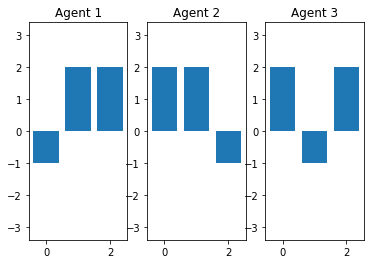

In [11]:
env = Environment(3,3, liste_agents_A) 
env.init_state(state_E)

#env.init_state(new_s)
env.show()

[]


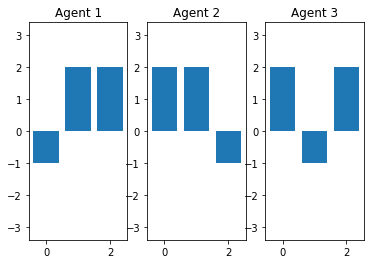

In [12]:
#env.init_state(new_s)
env.show()
print(env.hist_SW)

In [13]:
def episode(env):
    n_agents = env.n_agents
    n_items = env.n_items
    opt_sw = env.optimal_social_welfare()
    env.next_round()
    
    env.states_history.append(env.state)
    current_SW = env.global_utility(env.state)
    env.hist_SW.append(current_SW)
    
    for i_A in range(n_agents):
        uti_agent = env.local_utility(env.state, i_A)
        env.hist_ut_agents[i_A].append(uti_agent)
    
    env.show()

        
    
    demands = np.zeros([n_agents, n_items])
    
    
    coop_degrees = np.zeros([n_agents, n_agents])
    
    for i_agent in range(n_agents):
        transa = env.agents[i_agent].offer(env)
        env.agents[i_agent].last_offers.append(transa)
        #print(transa)
        
        print("Agent ",i_agent)
        coop_deg_detected = env.agents[i_agent].coop_detection(env)
        print("coop deg detected ", coop_deg_detected)
        
        coop_deg_i = env.agents[i_agent].negociation(coop_deg_detected)
        print("coop deg negociated ", coop_deg_i)
        print()
        
        
        demands[i_agent, : ] = transa
        coop_degrees[i_agent,:] = coop_deg_i
        
    coop_degrees = np.clip(coop_degrees,0,1)
    
    print(coop_degrees)
    env.hist_coop_degrees.append(coop_degrees)
    
    
    env.allocation(coop_degrees, demands)
    #print(np.sum(env.state, axis=1))



In [14]:
def mean_coop_degrees(matrix_list):
    if matrix_list == []:
        return []
    else:
        (n_A,_) = np.shape(matrix_list[0])
        output = [ [[] for _ in range(n_A)], [[] for _ in range(n_A)] ]  #curves for mean receiving AND sending coop degree 
        for coop_degrees_mat in matrix_list:
            rece_coop = coop_degrees_mat.sum(0)
            send_coop = coop_degrees_mat.sum(1)
            for i_A in range(n_A):
                mean_rece = (rece_coop[i_A] - coop_degrees_mat[i_A,i_A])/(n_A-1)
                output[0][i_A].append(mean_rece)    #receiving coop degree mean for agent i_A

                mean_send = (send_coop[i_A] - coop_degrees_mat[i_A,i_A])/(n_A-1)
                output[1][i_A].append(mean_send)    #receiving coop degree mean for agent i_A

        return output

In [15]:
def figure_utilities(sw, list_ut, output_fig, max_t, lu=2,uu=4):
    colors = ['b','m','c','r']
    t_max = min(len(sw), max_t)
    t = np.arange(t_max)
    
    fig, ax1 = plt.subplots()

    color = 'b'
    ax1.set_xlabel('Rounds', fontsize = 14)
    ax1.set_ylabel('Social Welfare', color='g', fontsize = 14)
    ax1.plot(t, sw[:t_max], color='g', label="Social Welfare")
    ax1.tick_params(axis='y', labelcolor='g', labelsize = 14)
    plt.legend(loc=2, fontsize=13)

    ax2 = ax1.twinx()  
    ax2.set_ylabel('Individual Utility', color=color, fontsize = 14) 
    ax2.set_ylim(lu, uu)
    ax2.tick_params(axis='y', labelcolor=color, labelsize = 14)
    ax1.tick_params(axis='x', labelsize = 14)



    for i_A in range(len(list_ut)):
        color = colors[i_A]
        label = "Agent "+str(i_A+1)
        if i_A == 5:
            label = "Egoist"
        ax2.plot(t, list_ut[i_A][:t_max], color=color, label=label)
    
    plt.legend(loc=4, fontsize=13)
        
    fig.tight_layout() # otherwise the right y-label is slightly clipped
    fig.savefig(output_fig)
    plt.show()

In [16]:
def figure_coop_degrees_mean(list_coop, output_fig, max_t, lc=0 ,uc=1):
    colors = ['b','m','c','g','r']
    
    t_max = min(len(list_coop[0][0]), max_t)
    t = np.arange(t_max)

    fig, ax1 = plt.subplots()

    color = 'b'
    ax1.set_xlabel('Rounds', fontsize=14)
    ax1.set_ylabel('Mean Cooperation Degree',fontsize=14)

    ax1.set_ylim(lc, uc)

    ax1.tick_params(axis='y', labelsize=14)
    ax1.tick_params(axis='x', labelsize=14)
    


    for i_A in range(len(list_coop[0])):
        color = colors[i_A]
        if i_A != 5:
            label = "Agent "+str(i_A+1)
        else:
            label = "Egoist"
        ax1.plot(t, list_coop[0][i_A][:t_max], color, label = label + " : receiving")
        ax1.plot(t, list_coop[1][i_A][:t_max], color+"--", label = label + " : sending")
        plt.legend(loc=4,fontsize=13)
        
    fig.tight_layout() # otherwise the right y-label is slightly clipped
    fig.savefig(output_fig)
    plt.show()

In [17]:
def affiche(env, output,lu,uu,lc,uc):
    yA = env.hist_ut_agents[0]
    yB = env.hist_ut_agents[1]
    yC = env.hist_ut_agents[2]
    #yD = env.hist_ut_agents[3]
    y = env.hist_SW

    yA = [-x for x in yA]
    yB = [-x for x in yB]
    yC = [-x for x in yC]
    #yD = [-x for x in yD]
    y = [-x for x in y]
    
    mean_coop_degrees_expe = mean_coop_degrees(env.hist_coop_degrees)
    
    figure_utilities(y, [yA,yB,yC],'evolution_utilities_'+output+'.svg',10, lu, uu)
    
    figure_coop_degrees_mean(mean_coop_degrees_expe, 'evolution_cooperation_'+output+'.svg',10, lc, uc)
    

In [18]:
env = Environment(3,3, liste_agents_A)
env.init_state(state_E)


In [19]:
def effiency(list_SW, SWopt):
    SW0 = list_SW[0]
    output = []
    
    for sw in list_SW:
        e = min((-sw+SW0)/(-SWopt+SW0),1)
        output.append(e)
        
    return output
    

In [20]:
from sklearn import metrics

def speed(list_eff, T):
    final_efficiency = list_eff[-1]
    x = np.arange(T)    
    return metrics.auc(x, list_eff[:T])/(T*final_efficiency)

In [21]:
def analyse(state, beta, r, alpha, N_iter=10):
    algo = TFT(beta,r,alpha)
    egoist = TFT(1,0,0.5)

    n_A, n_I = np.shape(state)
    
    T_speed = 10
    
    T_speed = min(T_speed, N_iter)

    
    a1 = Agent(0, n_A, n_I, algo)
    a2 = Agent(1, n_A, n_I, algo)
    a3 = Agent(2, n_A, n_I, algo)

    b1 = Agent(0, n_A, n_I, algo)
    b2 = Agent(1, n_A, n_I, algo)
    b3 = Agent(2, n_A, n_I, egoist)
    
    c1 = Agent(0, n_A, n_I, algo)
    c2 = Agent(1, n_A, n_I, egoist)
    c3 = Agent(2, n_A, n_I, egoist)

    liste_agents_A = [a1, a2, a3]
    liste_agents_B = [b1, b2, b3]
    liste_agents_C = [c1, c2, c3]
    
    envA = Environment(n_A,n_I, liste_agents_A)
    envA.init_state(state_E)
    
    envB = Environment(n_A,n_I, liste_agents_B)
    envB.init_state(state_E)
    
    envC = Environment(n_A,n_I, liste_agents_C)
    envC.init_state(state_E)
    
    tra, ns, swopt = envA.optimize_globably()
    
    
    for i_ep in range(N_iter):
        print("Env A, episode ", i_ep)
        episode(envA)
        
    for i_ep in range(N_iter):
        print("Env B, episode ", i_ep)
        episode(envB)
        
    for i_ep in range(N_iter):
        print("Env C, episode ", i_ep)
        episode(envC)
        
    
    effic = effiency(envA.hist_SW, swopt)
    
    ef = effic[-1]

    sp = speed(effic, T_speed)
    
    ut_max_pers_nices = -1*envA.hist_ut_agents[2][-1] #positive
    ut_pers_3egoist = -1*envA.hist_ut_agents[0][0] #positive  
    ut_pers_1egoist = -1*envB.hist_ut_agents[2][-1] #positive
    ut_pers_2egoist = -1*envC.hist_ut_agents[0][-1] #positive

    
    print(ut_max_pers_nices, ut_pers_1egoist, ut_pers_2egoist, ut_pers_3egoist)
    
    ic = (ut_max_pers_nices-ut_pers_1egoist)/ut_max_pers_nices
    sf = (ut_pers_2egoist-ut_pers_3egoist)
    
    
    
    return [[beta, r, alpha],[envA, envB, envC], ef, sp, ut_max_pers_nices, ut_pers_1egoist, ut_pers_2egoist, ut_pers_3egoist]
    
    
    
    

Stopping search: Swarm best objective change less than 1e-08
Env A, episode  0
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Agent  0
coop deg detected  [0. 0. 0.]
coop deg negociated  [0.09 0.09 0.09]

Stopping search: Swarm best objective change less than 1e-08
Agent  1
coop deg detected  [0. 0. 0.]
coop deg negociated  [0.09 0.09 0.09]

Stopping search: Swarm best objective change less than 1e-08
Agent  2
coop deg detected  [0. 0. 0.]
coop deg negociated  [0.09 0.09 0.09]

[[0.09 0.09 0.09]
 [0.09 0.09 0.09]
 [0.09 0.09 0.09]]
Env A, episode  1
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Agent  0
coop deg detected  [0.         0.10040622 0.09997061]
coop deg negociated  [0.099      0.18032904 0.1799762 ]

Stopping search: Swarm best objective change less than 1e-08
Agent  1
coop deg detected  [0.09829865 0.         0.09942093]
coop

Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Agent  0
coop deg detected  [0.         0.20418934 0.        ]
coop deg negociated  [0.0999     0.27314863 0.0999    ]

Stopping search: Swarm best objective change less than 1e-08
Agent  1
coop deg detected  [0.19839211 0.         0.        ]
coop deg negociated  [0.2685379 0.0999    0.0999   ]

Stopping search: Swarm best objective change less than 1e-08
Agent  2
coop deg detected  [0.10656726 0.10395568 0.        ]
coop deg negociated  [0. 0. 0.]

[[0.0999     0.27314863 0.0999    ]
 [0.2685379  0.0999     0.0999    ]
 [0.         0.         0.        ]]
Env B, episode  3
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Agent  0
coop deg detected  [0.         0.29611643 0.        ]
coop deg negociated  [0.09999    0.35716917 0.09999   ]

Stopping search: Swarm best objective change less than

/usr/local/Cellar/ipython/7.8.0/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:188: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Stopping search: Swarm best objective change less than 1e-08
Agent  0
coop deg detected  [0. 0. 0.]
coop deg negociated  [0.09 0.09 0.09]

Stopping search: Swarm best objective change less than 1e-08
Agent  1
coop deg detected  [0. 0. 0.]
coop deg negociated  [0. 0. 0.]

Stopping search: Swarm best objective change less than 1e-08
Agent  2
coop deg detected  [0. 0. 0.]
coop deg negociated  [0. 0. 0.]

[[0.09 0.09 0.09]
 [0.   0.   0.  ]
 [0.   0.   0.  ]]
Env C, episode  1
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Agent  0
coop deg detected  [0. 0. 0.]
coop deg negociated  [0.099 0.099 0.099]

Stopping search: Swarm best objective change less than 1e-08
Agent  1
coop deg detected  [0.09086849 0.         0.        ]
coop deg negociated  [0. 0. 0.]

Stopping search: Swarm best objective change less than 1e-08
Agent  2
coop deg detected  [0.09561074 0.         0.        ]
coop deg negociated  [0. 0. 0.]

[[0.0

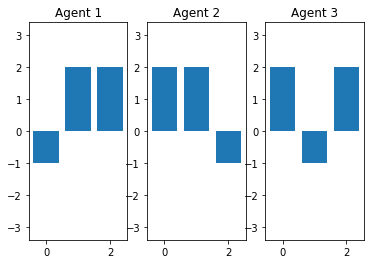

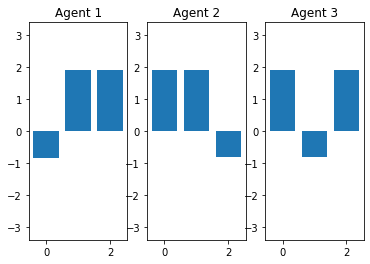

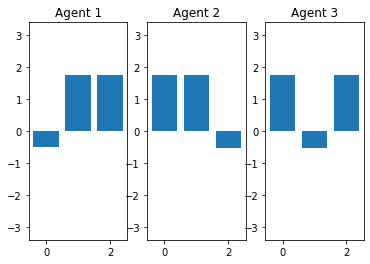

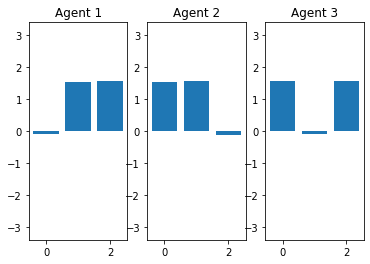

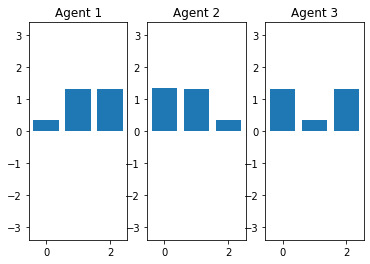

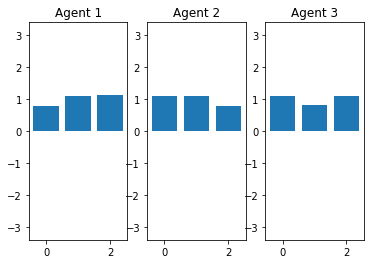

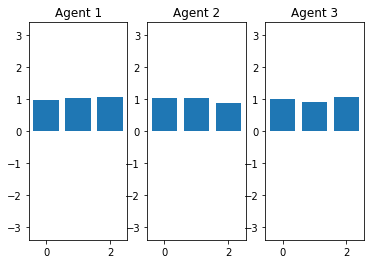

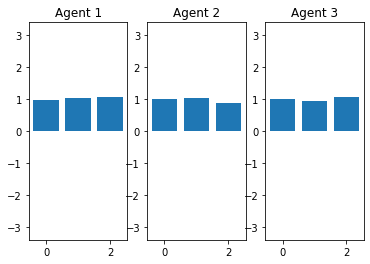

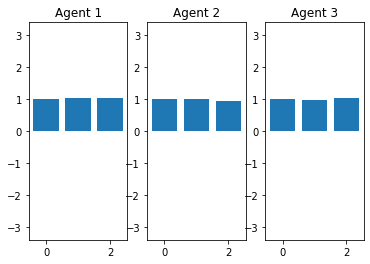

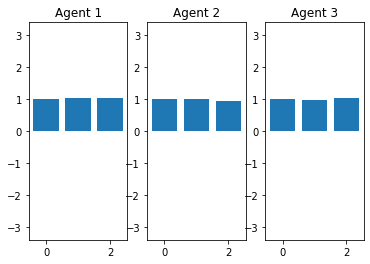

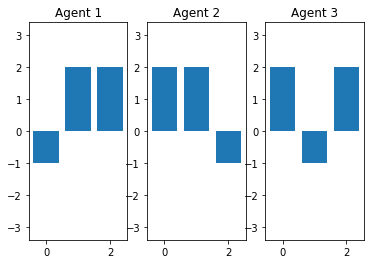

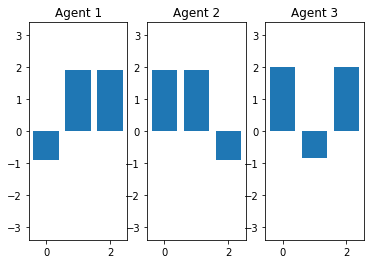

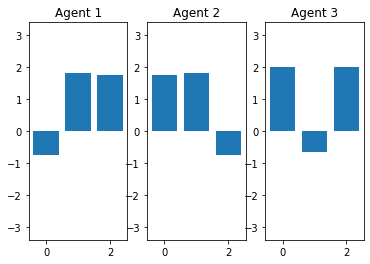

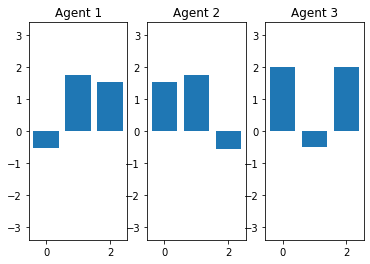

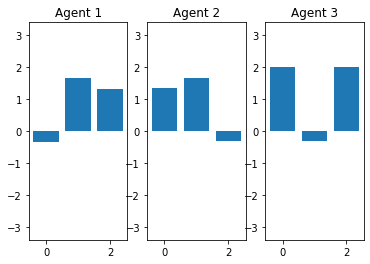

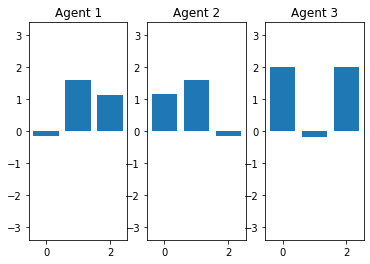

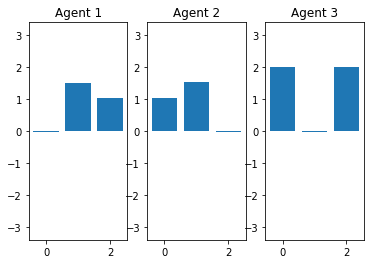

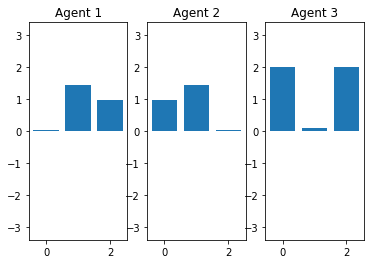

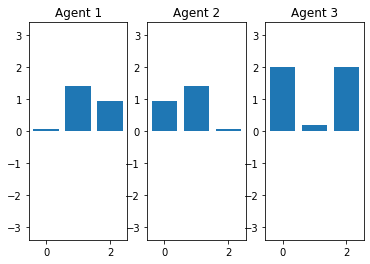

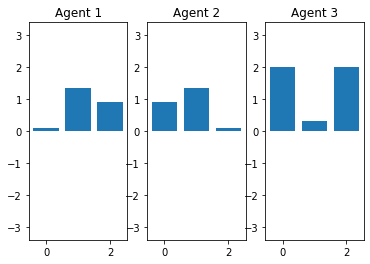

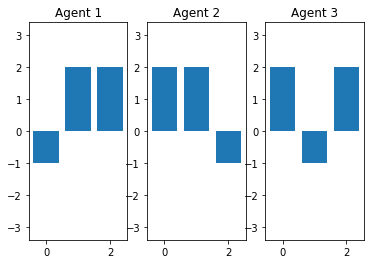

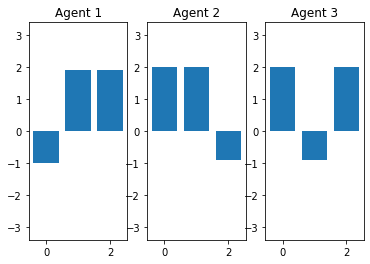

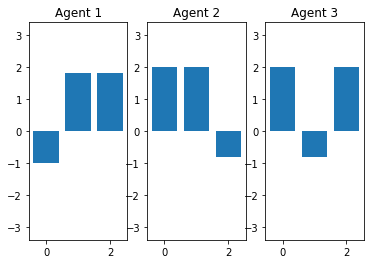

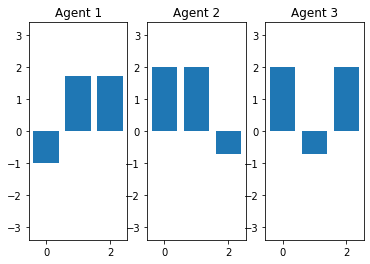

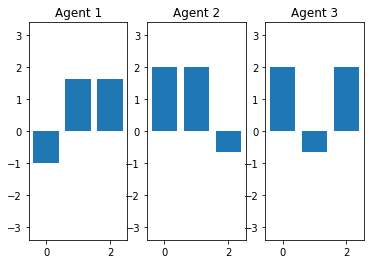

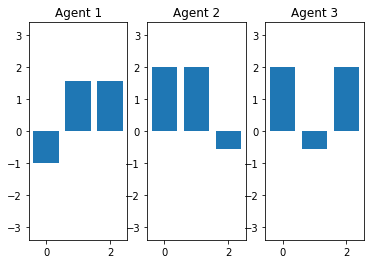

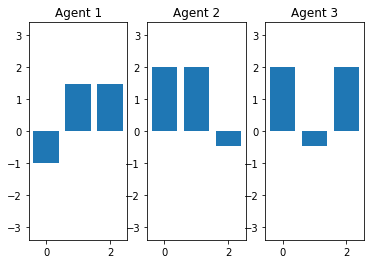

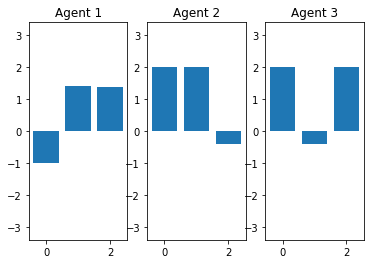

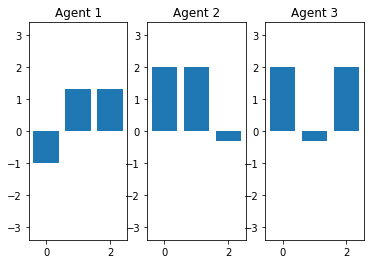

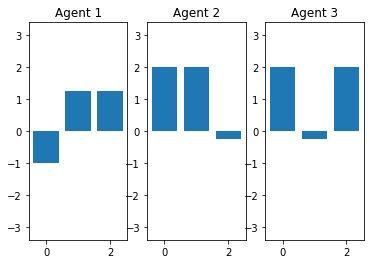

In [22]:
beta = 0.1
r = 0.1
alpha = 0
N_iter = 10
result = analyse(state_E, beta, r, alpha, N_iter)

In [23]:
envD = result[1][0]
envE = result[1][1]
envF = result[1][2]


ut_max_pers_nices = -1*envD.hist_ut_agents[2][-1] #positive
ut_pers_3egoist = -1*envD.hist_ut_agents[0][0] #positive  
ut_pers_1egoist = -1*envE.hist_ut_agents[2][-1] #positive
ut_pers_2egoist = -1*envF.hist_ut_agents[0][-1] #positive

ic = ut_max_pers_nices-ut_pers_1egoist
sf = ut_pers_2egoist - ut_pers_3egoist

print(ic, sf)

print(ut_max_pers_nices, ut_pers_1egoist, ut_pers_2egoist, ut_pers_3egoist)

-0.31375274992302904 -0.420028915643309
3.2973324320921362 3.6110851820151653 2.352559821596472 2.772588737239781


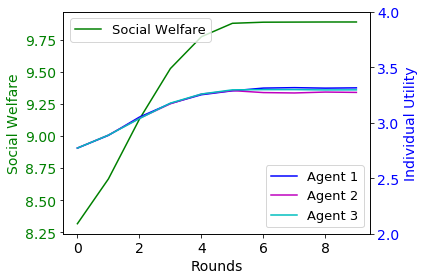

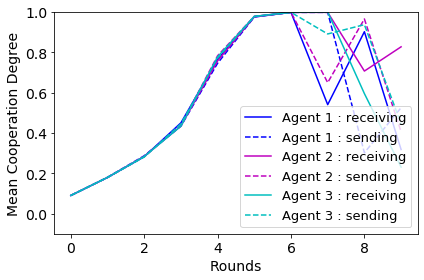

In [27]:
affiche(envD,'One_egoist',2,4,-0.1,1)

In [28]:
def all_expe(liste_bra):
    output = []
    for x in liste_bra:
        beta, r, alpha = x
        N_iter = 15
        a = analyse(state_E, beta, r, alpha, N_iter)
        output.append(a)
    
    return output

In [29]:
liste_exp = [(0.1,0.05,0),(0.1,0.02,0)]
#liste_exp = [(0.1,0.05,0),(0.1,0.02,0),(0.3,0.1,0),(0.5,0.1,0),(0.7,0.1,0),(0.1,0.1,0.3),(0.1,0.1,0.5),(0.1,0.1,0.7)]

Stopping search: Swarm best objective change less than 1e-08
Env A, episode  0
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Agent  0
coop deg detected  [0. 0. 0.]
coop deg negociated  [0.045 0.045 0.045]

Stopping search: Swarm best objective change less than 1e-08
Agent  1
coop deg detected  [0. 0. 0.]
coop deg negociated  [0.045 0.045 0.045]

Stopping search: Swarm best objective change less than 1e-08
Agent  2
coop deg detected  [0. 0. 0.]
coop deg negociated  [0.045 0.045 0.045]

[[0.045 0.045 0.045]
 [0.045 0.045 0.045]
 [0.045 0.045 0.045]]
Env A, episode  1
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Agent  0
coop deg detected  [0.         0.04751561 0.04669681]
coop deg negociated  [0.0495     0.09012585 0.08942577]

Stopping search: Swarm best objective change less than 1e-08
Agent  1
coop deg detected  [0.04640292 0.       

Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Agent  0
coop deg detected  [0.         0.03710644 0.        ]
coop deg negociated  [0.05       0.0904525  0.08240409]

Stopping search: Swarm best objective change less than 1e-08
Agent  1
coop deg detected  [1. 0. 1.]
coop deg negociated  [0.9059496  0.05       0.99214685]

Stopping search: Swarm best objective change less than 1e-08
Agent  2
coop deg detected  [0.11021836 0.18583839 0.        ]
coop deg negociated  [0.16771812 0.29657745 0.05      ]

[[0.05       0.0904525  0.08240409]
 [0.9059496  0.05       0.99214685]
 [0.16771812 0.29657745 0.05      ]]
Env A, episode  13
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Agent  0
coop deg detected  [0.         0.00553613 0.        ]
coop deg negociated  [0.05       0.05877864 0.05324041]

Stopping search: Swarm best objective change less 

/usr/local/Cellar/ipython/7.8.0/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:188: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Stopping search: Swarm best objective change less than 1e-08
Agent  0
coop deg detected  [0.         0.20795583 0.        ]
coop deg negociated  [0.04999995 0.24524254 0.04999995]

Stopping search: Swarm best objective change less than 1e-08
Agent  1
coop deg detected  [0.22042439 0.         0.        ]
coop deg negociated  [0.25552801 0.04999995 0.04999995]

Stopping search: Swarm best objective change less than 1e-08
Agent  2
coop deg detected  [0.05097859 0.05215501 0.        ]
coop deg negociated  [0. 0. 0.]

[[0.04999995 0.24524254 0.04999995]
 [0.25552801 0.04999995 0.04999995]
 [0.         0.         0.        ]]
Env B, episode  6
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Agent  0
coop deg detected  [0.         0.21863225 0.        ]
coop deg negociated  [0.05       0.25645483 0.05      ]

Stopping search: Swarm best objective change less than 1e-08
Agent  1
coop deg detected  [0.2113961 0.        0.

Stopping search: Swarm best objective change less than 1e-08
Agent  0
coop deg detected  [0. 0. 0.]
coop deg negociated  [0.04995 0.04995 0.04995]

Stopping search: Swarm best objective change less than 1e-08
Agent  1
coop deg detected  [0.04957823 0.         0.        ]
coop deg negociated  [0. 0. 0.]

Stopping search: Swarm best objective change less than 1e-08
Agent  2
coop deg detected  [0.05085695 0.         0.        ]
coop deg negociated  [0. 0. 0.]

[[0.04995 0.04995 0.04995]
 [0.      0.      0.     ]
 [0.      0.      0.     ]]
Env C, episode  3
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Agent  0
coop deg detected  [0. 0. 0.]
coop deg negociated  [0.049995 0.049995 0.049995]

Stopping search: Swarm best objective change less than 1e-08
Agent  1
coop deg detected  [0.05236181 0.         0.        ]
coop deg negociated  [0. 0. 0.]

Stopping search: Swarm best objective change less than 1e-08
Agent  2

Stopping search: Swarm best objective change less than 1e-08
Agent  2
coop deg detected  [0. 0. 0.]
coop deg negociated  [0.018 0.018 0.018]

[[0.018 0.018 0.018]
 [0.018 0.018 0.018]
 [0.018 0.018 0.018]]
Env A, episode  1
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Agent  0
coop deg detected  [0.         0.01788671 0.01858006]
coop deg negociated  [0.0198     0.03557608 0.03618761]

Stopping search: Swarm best objective change less than 1e-08
Agent  1
coop deg detected  [0.01846567 0.         0.01837363]
coop deg negociated  [0.03608672 0.0198     0.03600554]

Stopping search: Swarm best objective change less than 1e-08
Agent  2
coop deg detected  [0.01778643 0.01827914 0.        ]
coop deg negociated  [0.03548763 0.03592221 0.0198    ]

[[0.0198     0.03557608 0.03618761]
 [0.03608672 0.0198     0.03600554]
 [0.03548763 0.03592221 0.0198    ]]
Env A, episode  2
Stopping search: Swarm best objective change 

Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Agent  0
coop deg detected  [0. 1. 1.]
coop deg negociated  [0.02       0.97905702 0.99299492]

Stopping search: Swarm best objective change less than 1e-08
Agent  1
coop deg detected  [1. 0. 1.]
coop deg negociated  [0.9946933  0.02       0.97671845]

Stopping search: Swarm best objective change less than 1e-08
Agent  2
coop deg detected  [1. 1. 0.]
coop deg negociated  [0.97841795 0.99452592 0.02      ]

[[0.02       0.97905702 0.99299492]
 [0.9946933  0.02       0.97671845]
 [0.97841795 0.99452592 0.02      ]]
Env A, episode  13
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Agent  0
coop deg detected  [0. 1. 1.]
coop deg negociated  [0.02       0.9979057  0.99929949]

Stopping search: Swarm best objective change less than 1e-08
Agent  1
coop deg detected  [1. 0. 1.]
coop deg negociated  [

Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Agent  0
coop deg detected  [0.         0.10185517 0.        ]
coop deg negociated  [0.02       0.12063884 0.02      ]

Stopping search: Swarm best objective change less than 1e-08
Agent  1
coop deg detected  [0.10775691 0.         0.        ]
coop deg negociated  [0.12573818 0.02       0.02      ]

Stopping search: Swarm best objective change less than 1e-08
Agent  2
coop deg detected  [0.01910841 0.0208833  0.        ]
coop deg negociated  [0. 0. 0.]

[[0.02       0.12063884 0.02      ]
 [0.12573818 0.02       0.02      ]
 [0.         0.         0.        ]]
Env B, episode  10
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Agent  0
coop deg detected  [0.         0.10615534 0.        ]
coop deg negociated  [0.02       0.12369289 0.02      ]

Stopping search: Swarm best objective change less 

Stopping search: Swarm best objective change less than 1e-08
Agent  2
coop deg detected  [0.02049855 0.         0.        ]
coop deg negociated  [0. 0. 0.]

[[0.02 0.02 0.02]
 [0.   0.   0.  ]
 [0.   0.   0.  ]]
Env C, episode  7
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Agent  0
coop deg detected  [0. 0. 0.]
coop deg negociated  [0.02 0.02 0.02]

Stopping search: Swarm best objective change less than 1e-08
Agent  1
coop deg detected  [0.01918052 0.         0.        ]
coop deg negociated  [0. 0. 0.]

Stopping search: Swarm best objective change less than 1e-08
Agent  2
coop deg detected  [0.02021489 0.         0.        ]
coop deg negociated  [0. 0. 0.]

[[0.02 0.02 0.02]
 [0.   0.   0.  ]
 [0.   0.   0.  ]]
Env C, episode  8
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Agent  0
coop deg detected  [0. 0. 0.]
coop deg negociated  [

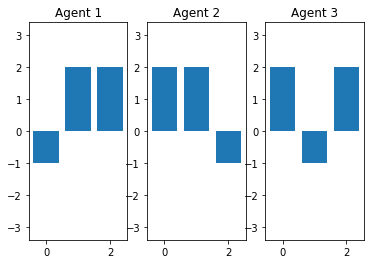

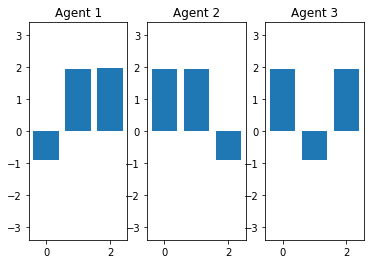

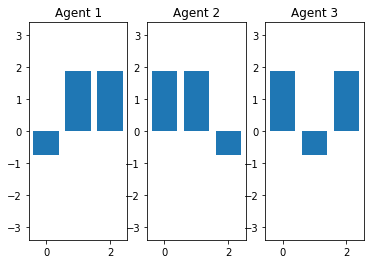

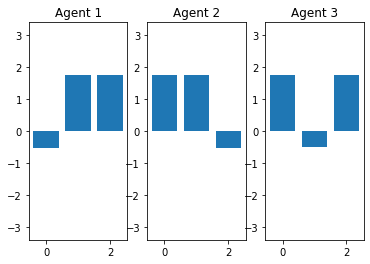

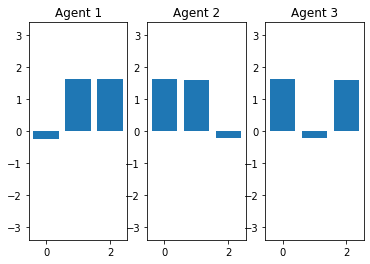

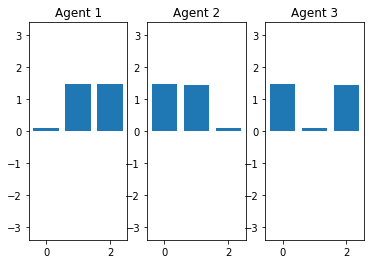

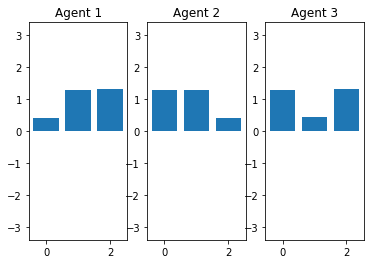

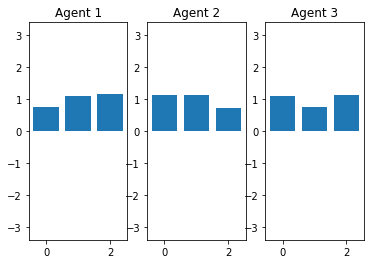

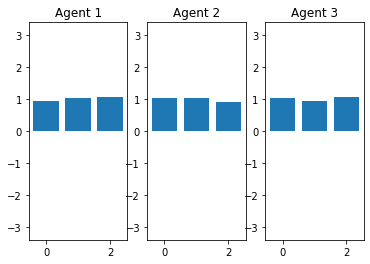

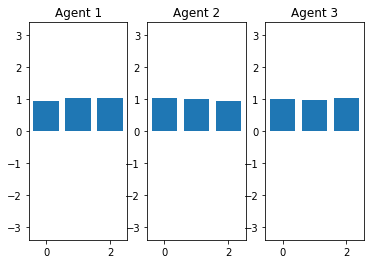

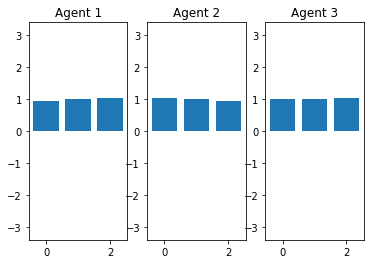

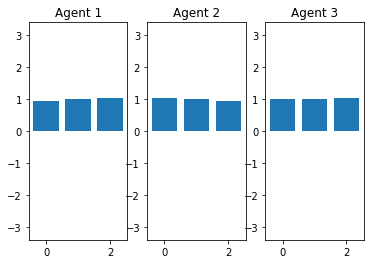

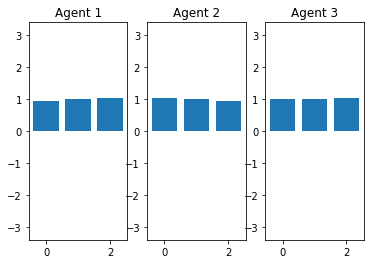

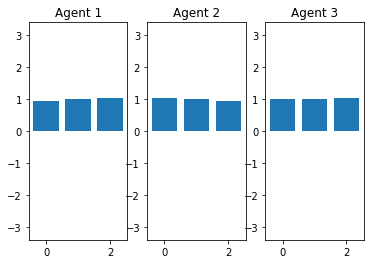

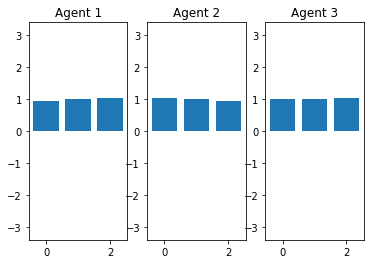

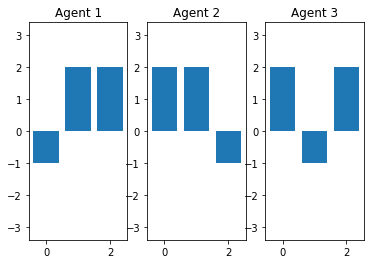

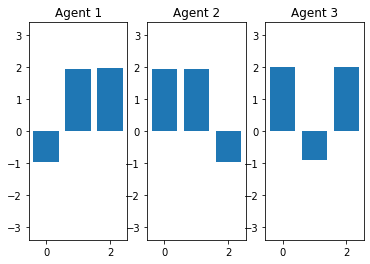

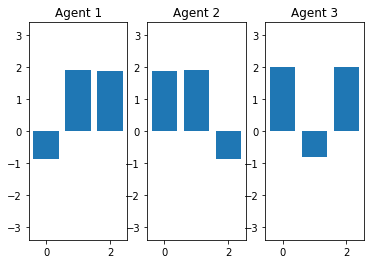

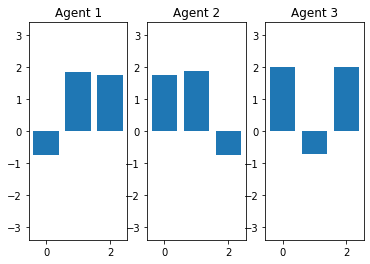

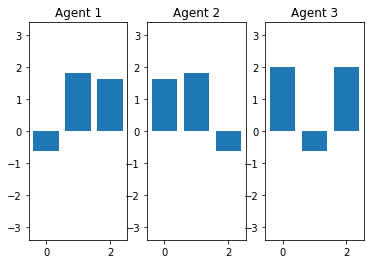

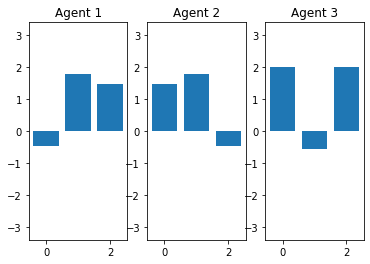

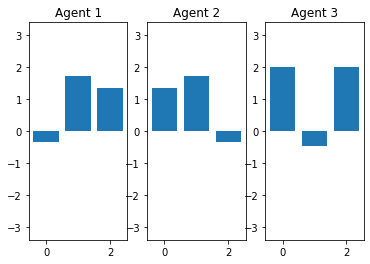

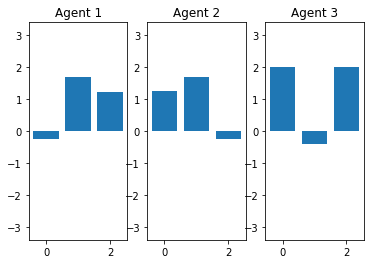

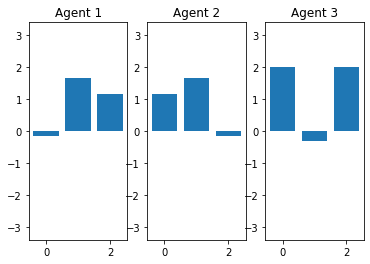

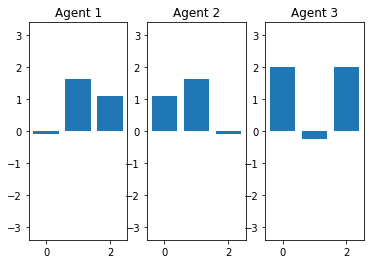

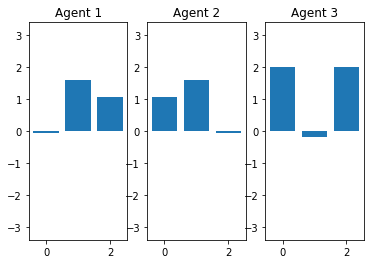

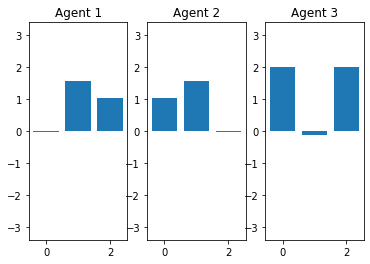

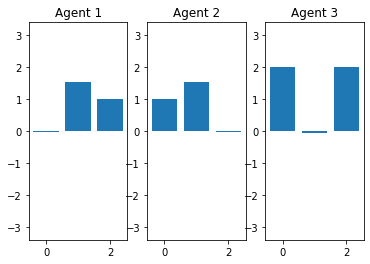

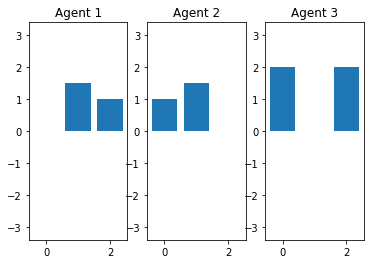

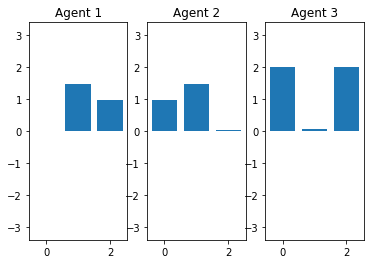

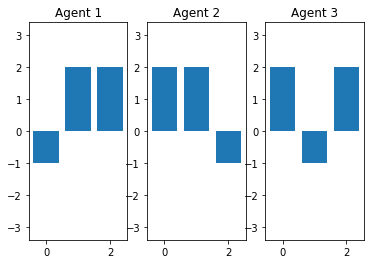

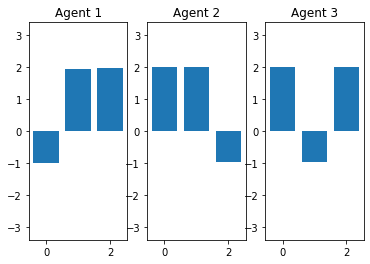

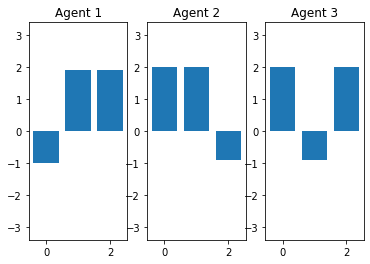

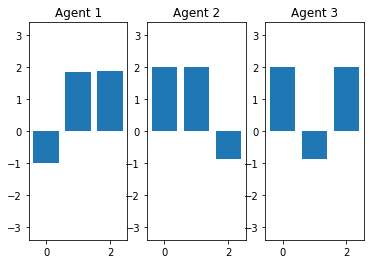

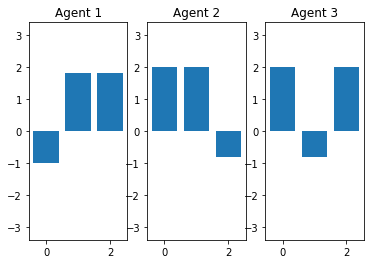

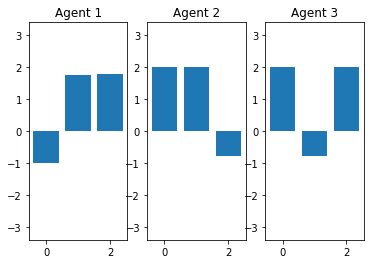

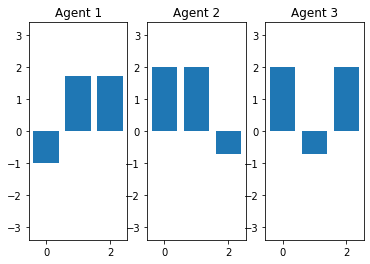

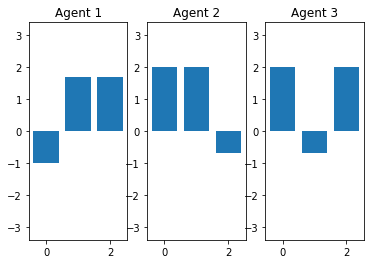

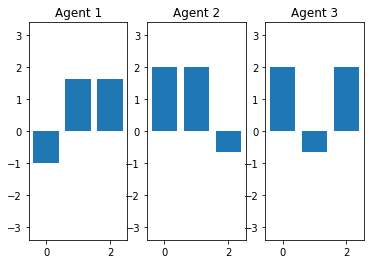

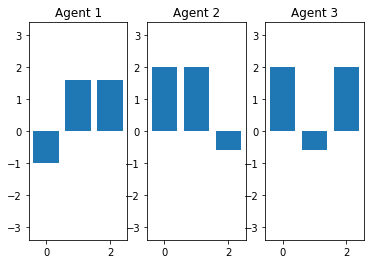

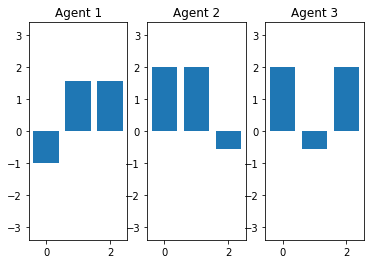

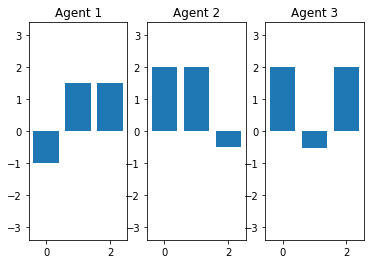

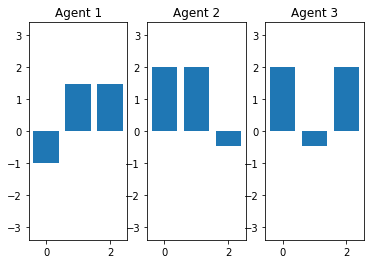

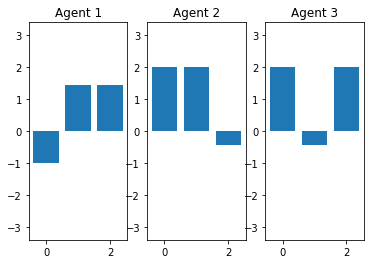

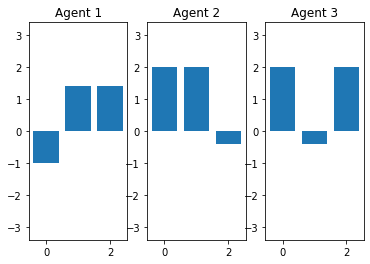

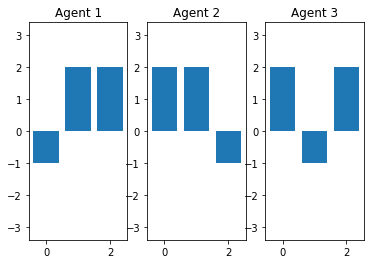

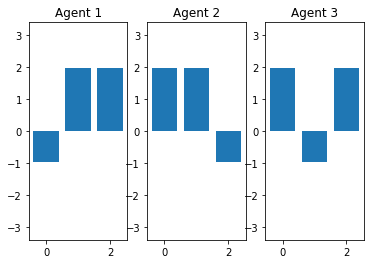

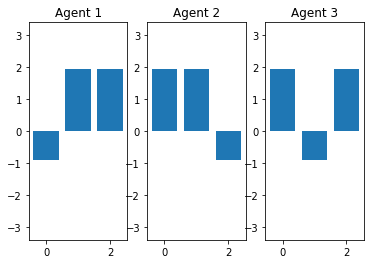

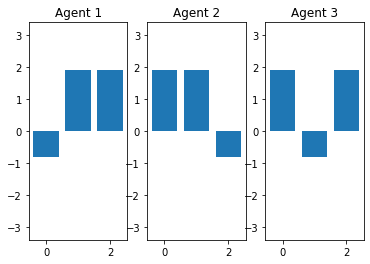

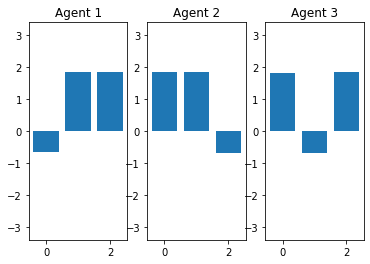

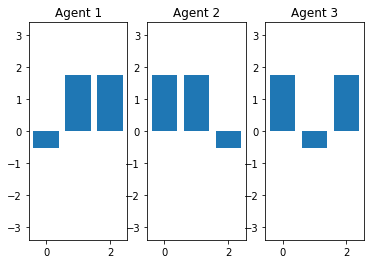

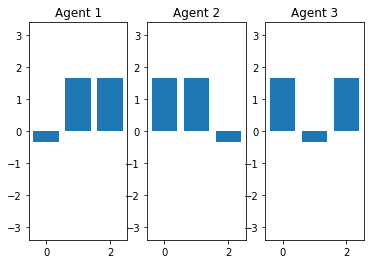

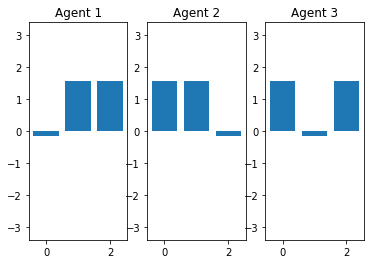

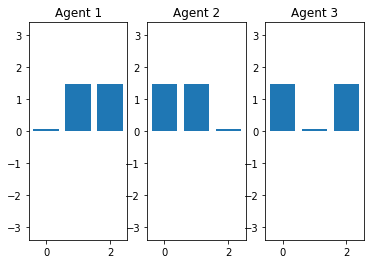

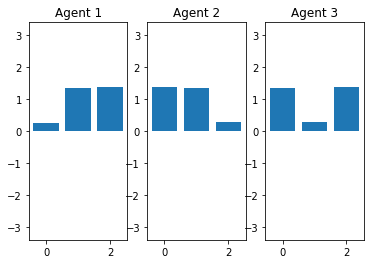

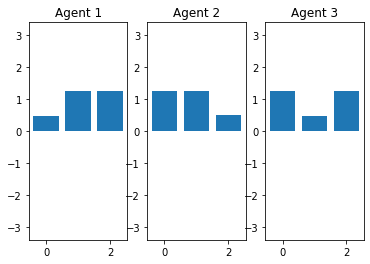

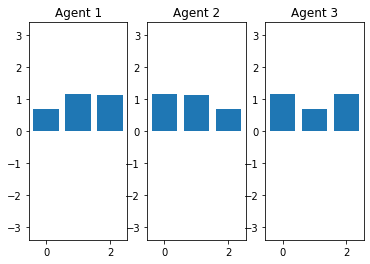

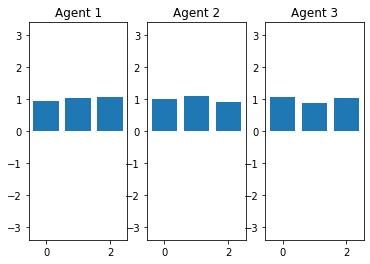

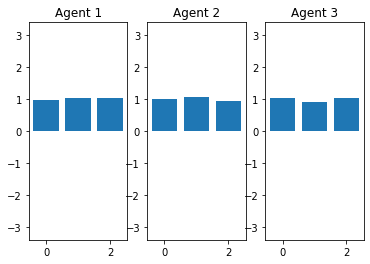

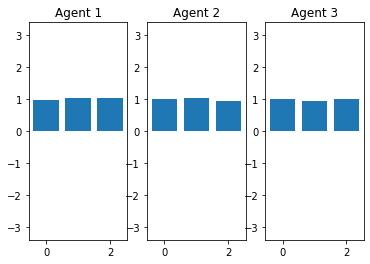

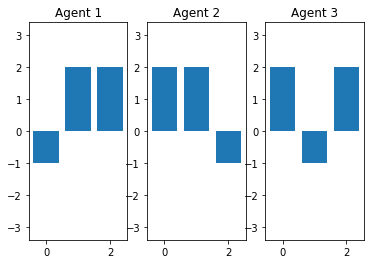

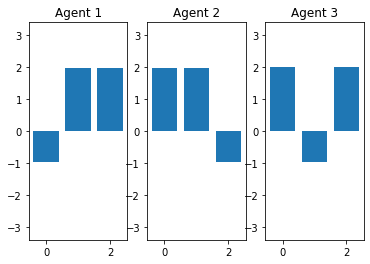

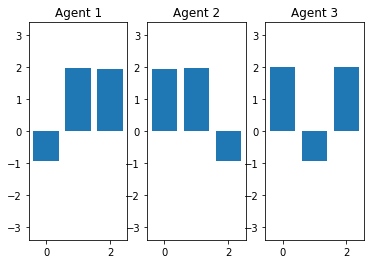

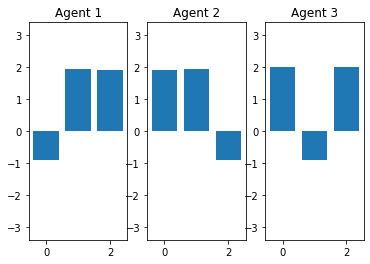

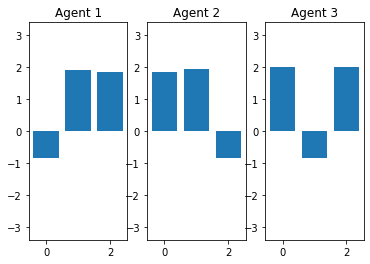

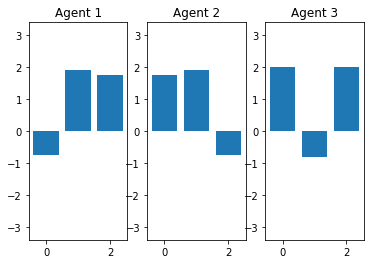

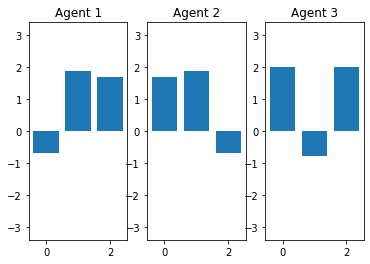

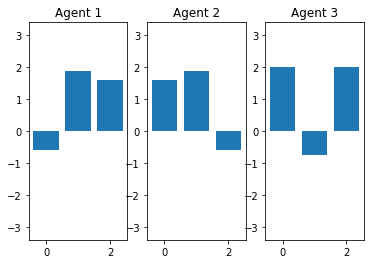

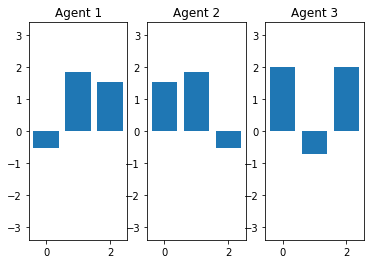

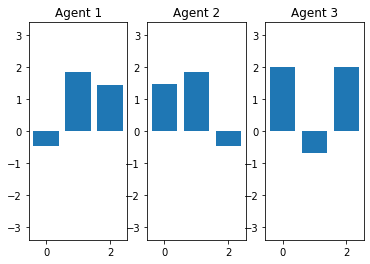

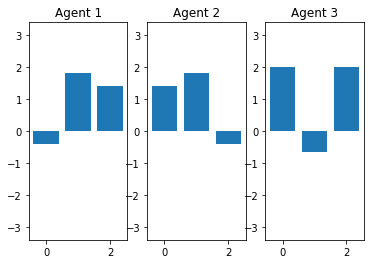

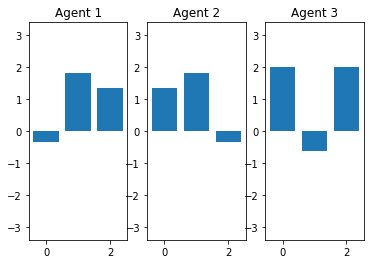

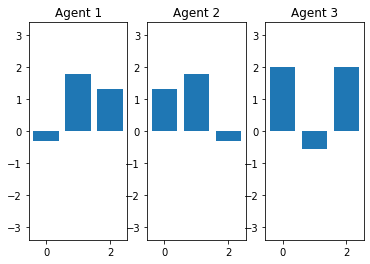

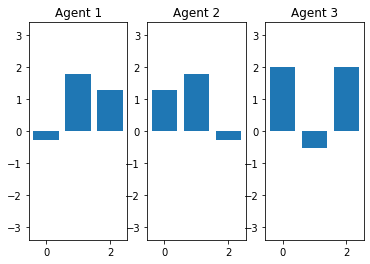

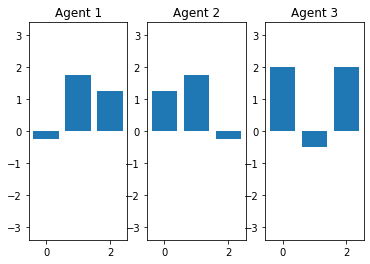

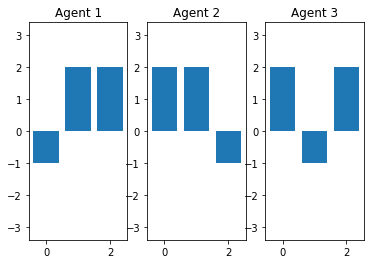

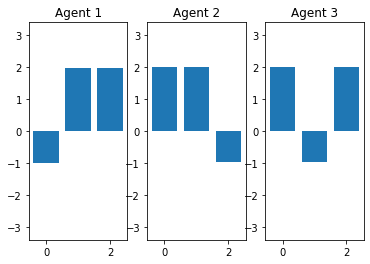

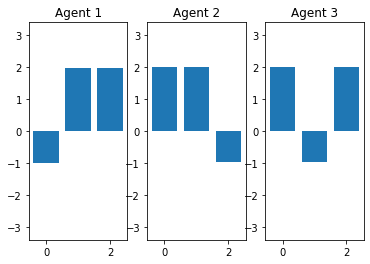

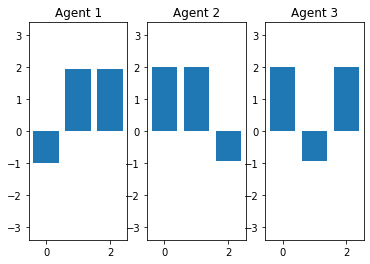

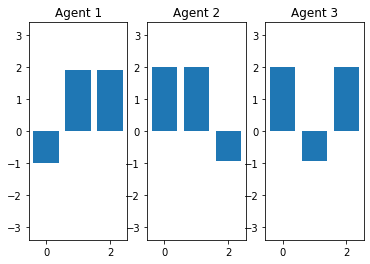

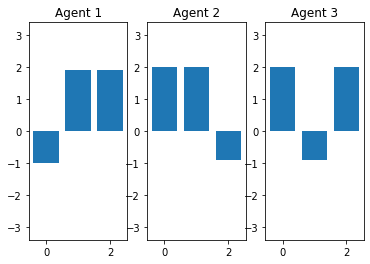

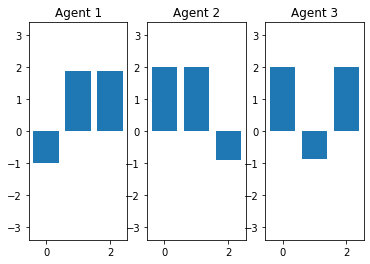

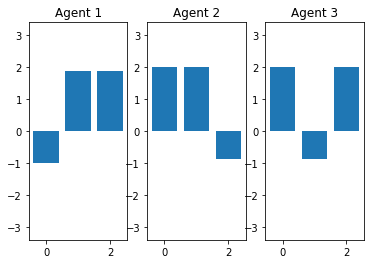

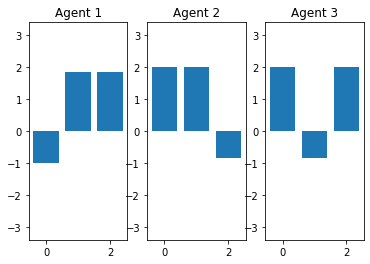

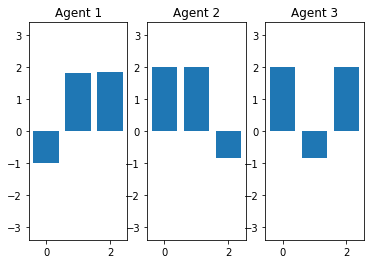

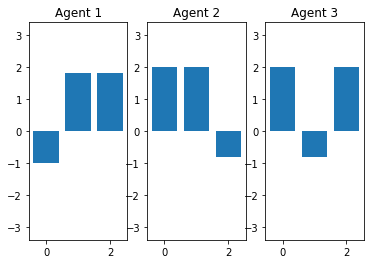

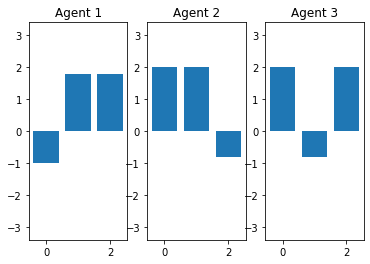

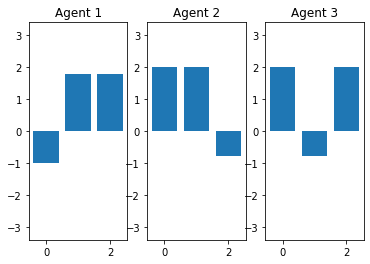

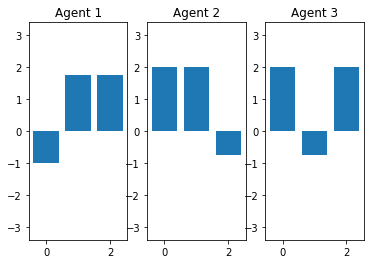

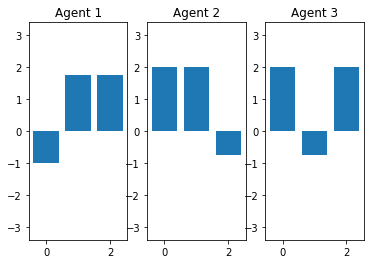

In [30]:
output = all_expe(liste_exp)

In [31]:
for x in output:
    param,_,e,sp,utN,ut1E,ut2E,ut3E = x
    print(param, e, sp, ut1E, ut2E)

[0.1, 0.05, 0] 1 0.5952292151960095 3.504279961168541 2.4452657901439414
[0.1, 0.02, 0] 1 0.40250306541774766 3.171127456883163 2.6397848495736733
